In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

In [ ]:
pip install yfinance

In [90]:
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM , Dropout
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

LOOK_BACK = 4

## **predict bitcoin daily return**

[*********************100%***********************]  1 of 1 completed


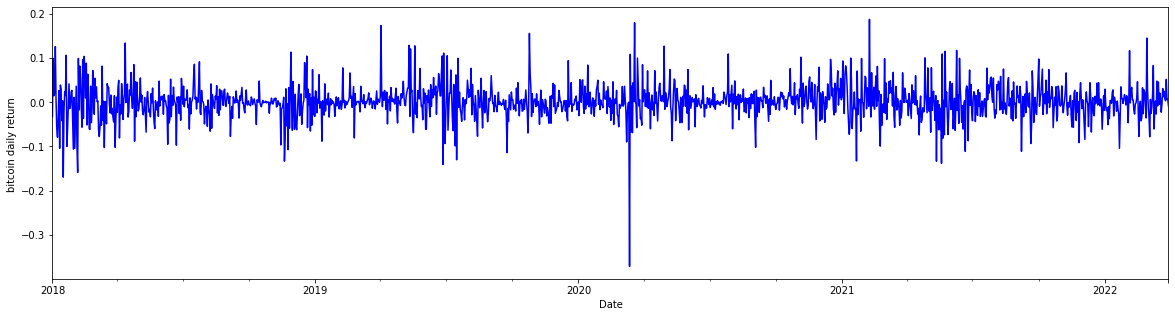

,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,-0.032242
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,0.099604
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,0.014875
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,0.021512
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,0.126140


In [94]:

def get_bitcoin_candlestick(start_date, end_date):

    """  get bitcoin daily info from yahooFinance and remove non values"""

    btc_df = yf.download("BTC-USD", start_date, end_date,
                         auto_adjust=True)

    btc_df['daily_return'] = (btc_df['Close'] -
                                  btc_df['Open']) / btc_df['Open']

    btc_df = btc_df.dropna()

    btc_df.daily_return.plot(figsize=(20, 5), color='b')
    plt.ylabel("bitcoin daily return ")
    plt.show()
    
    return btc_df


  
btc_df = get_bitcoin_candlestick(start_date="2018-01-01",
                                 end_date="2022-03-30")
btc_df.head()

In [99]:

def train_test_split(train_length):
    """Normalize date column and split into train and test sets """

    scaler = preprocessing.StandardScaler()
    scaler.fit(btc_df[['daily_return']])
    btc_daily_return['daily_return'] = scaler.transform(
                                            btc_df[['daily_return']])

    train_size = int(len(btc_daily_return) * train_length)
    test_size = len(btc_daily_return) - train_size
    train = btc_daily_return[0:train_size]
    test = btc_daily_return[train_size:len(btc_daily_return)]

    return train, test


train, test = train_test_split(train_length=0.7)

In [101]:

def create_dataset(X, y, time_steps=1):
    """ reshape data to [samples, time_steps, n_features] """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


X_train, y_train = create_dataset(train, train.daily_return, LOOK_BACK)
X_test, y_test = create_dataset(test, test.daily_return, LOOK_BACK)
print(X_test.shape, y_test.shape)

(461, 4, 1) (461,)


Epoch 1/300
27/27 [==============================] - 3s 30ms/step - loss: 1.0925 - val_loss: 0.4828
Epoch 2/300
27/27 [==============================] - 0s 16ms/step - loss: 1.0879 - val_loss: 0.4823
Epoch 3/300
27/27 [==============================] - 0s 14ms/step - loss: 1.0859 - val_loss: 0.4831
Epoch 4/300
27/27 [==============================] - 0s 14ms/step - loss: 1.0807 - val_loss: 0.4834
Epoch 5/300
27/27 [==============================] - 0s 14ms/step - loss: 1.0790 - val_loss: 0.4827
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 1.0777 - val_loss: 0.4828
Epoch 7/300
27/27 [==============================] - 0s 9ms/step - loss: 1.0763 - val_loss: 0.4828
Epoch 8/300
27/27 [==============================] - 0s 9ms/step - loss: 1.0782 - val_loss: 0.4824
Epoch 9/300
27/27 [==============================] - 0s 8ms/step - loss: 1.0743 - val_loss: 0.4819
Epoch 10/300
27/27 [==============================] - 0s 8ms/step - loss: 1.0703 - val_loss: 0.4814
Epo

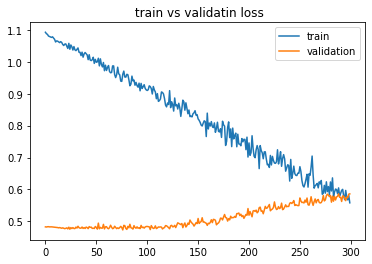

In [112]:
def btc_return_LSTM_prediction(Xtrain, ytrain, Xtest, ytest, epoch_num):

    # callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    model = Sequential()
    model.add(LSTM(units=128, activation='relu',
                   input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=10))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    history = model.fit(Xtrain, ytrain, epochs=epoch_num,
                        batch_size=32,
                        # callbacks=[callback],
                        validation_split=0.2,
                        verbose=1,
                        shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(" train vs validatin loss")
    plt.legend()

    return model


lstm_model = btc_return_LSTM_prediction(Xtrain=X_train, ytrain=y_train,
                                        Xtest=X_test, ytest=y_test, epoch_num=300)

 MSE of LSTM model on test data 
1.1794265053501551


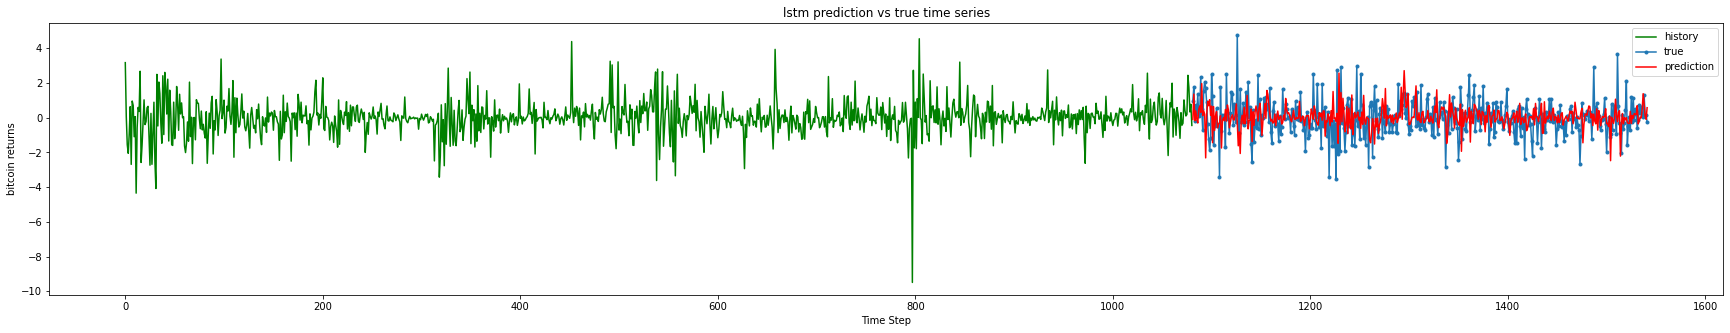

In [116]:

def evalute_LSTM_model(model):

    y_pred = model.predict(X_test)

    print(" MSE of LSTM model on test data ")
    print(np.sqrt(mean_squared_error(y_test, y_pred)))

    plt.figure(figsize=(30, 5))
    plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
             y_test, marker='.', label="true")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
             y_pred, 'r', label="prediction")
    plt.ylabel('bitcoin returns')
    plt.xlabel('Time Step')
    plt.title('lstm prediction vs true time series')
    plt.legend()
    plt.show()


evalute_LSTM_model(model)